In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import random

from argparse import Namespace
import os
import collections
from collections import Counter

import string
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# @@@@@ 0. Settings

In [2]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

In [3]:
args = Namespace(
    ### Training or loading
    get_model   = get_model,
    
    ### Data and Path information
    input_path  = os.getcwd(),
    output_path = os.getcwd()+'/OUTPUT/',
    save_model_name = 'ag_news_model.pth',
    
    ### Embedding - Use GloVe or randomly initialized embedding weights
    use_GloVe_embedding = True, 
    glove_filepath      = "glove.6B.100d.txt",
    
    ### Model hyperparameters
    cutoff           = 25,
    
    # nn.Embedding 
    # embedding_dim mean the dimension of embeddings. 
    # this is set to be 100 (same with glove.6B.100d) so that the pre-trained wieghts
    # can be loaded and used. 
    embedding_dim    = 100,        
    
    # nn.Conv1d
    num_channels     = 100, 
    
    # nn.Linear
    hidden_dim       = 100, 
    
    ### Training hyperparameters
    learning_rate    = 0.001,
    batch_size       = 128,
    dropout_p        = 0.1,
    device           = 'cpu',
    num_epochs       = 100,
    early_stopping_criteria = 5
)

# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches.
- ### Step 1: Creating a Vocabulary - mapping each token (words in the context of contexts) in the Frankenstein data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different contexts to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches.

## 1.1 - Read Data
### **Train partition**: a dataset to derive the model parameters
### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
### **Test partition**: a dataset for final evaluation and reporting

In [4]:
df_all = pd.read_csv('news_with_splits.csv')
df_all.sample(5)

,category,split,title
12725,Business,train,"Crude Sets Record, Nigeria Concerns Mount"
56036,Sci/Tech,test,Broadband Pushes Europe Web Users to 100 Million
61339,Sports,train,Knicks snap out of it
16706,Business,train,Bush seen keeping economic team for now
69524,Sports,train,Zambrano helps Cubs get ahead


In [5]:
df_all['category'].value_counts()

category
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64

## 1.2 - The Vocabulary/SequenceVocabulary class
### [A walkthrough of Vocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/class_Vocabulary.ipynb)
### [A walkthrough of SequenceVocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/class_SequenceVocabulary.ipynb)
### - The Vocabulary class will be used to create the vocabulary of categories, and the SequenceVocabulary class will be used to create the vocabulary of titles. These objects will be used in the Vectorization step (discussed next). 
### - The Vocabulary create a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary/SequenceVocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training. There is one additional optional step for creating the vocabulary - couting the tokens appeared in the "context" and "target" columns, and ONLY add frequent tokens that apprear more than a pre-specified number to the Vocabulary, while treat infrequent tokens as UNK.
### - SequenceVocabulary is a subclass of the standard Vocabulary class that bundles four special tokens used for sequence data: the UNK token, the MASK token, the BEGIN-OF-SEQUENCE token, and the END-OF-SEQUENCE token. 
#### (1) MASK tokens: serves as a sentinel for Embedding layers and loss calculations when we have sequences of variable length.
#### (2) BEGIN-OF-SEQUENCE and END-OF-SEQUENCE tokens: give the neural network hints about the sequence boundaries.
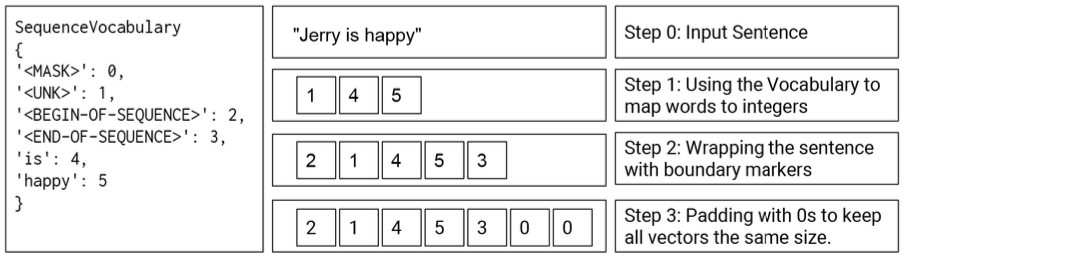
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.

In [6]:
class Vocabulary(object):

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """
        if token_to_idx is None:
            token_to_idx = {}
            
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            ### add a new element to _token_to_idx
            self._token_to_idx[token] = index
            ### add a new element to _idx_to_token
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, 
                 token_to_idx    = None, 
                 unk_token       = "<UNK>",
                 mask_token      = "<MASK>", 
                 begin_seq_token = "<BEGIN>",
                 end_seq_token   = "<END>"):
        
        
        super().__init__(token_to_idx)
        """
        The follow attributes have been defined in the Vocabulary class:
            - ._token_to_idx
            - ._idx_to_token
        """

        self._mask_token      = mask_token      # default: "<MASK>"
        self._unk_token       = unk_token       # default: "<UNK>"
        self._begin_seq_token = begin_seq_token # default: "<BEGIN>"
        self._end_seq_token   = end_seq_token   # default: "<END>"

        self.mask_index       = self.add_token(self._mask_token)      # return 0
        self.unk_index        = self.add_token(self._unk_token)       # return 1
        self.begin_seq_index  = self.add_token(self._begin_seq_token) # return 2
        self.end_seq_index    = self.add_token(self._end_seq_token)   # return 3
        
    
    ### Overriding the self.lookup_token() method
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/class_Vectorizer.ipynb)
### - The class method **from_dataframe()** is used to instantiate a NewsVectorizer object from a dataframe.
### - The title_vocab and category_vocab will be used as the reference for vector representation, which is a vector of integers representing the indices of the context.
### - The class method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a row of news_df and returns a vectorized representation (a vector) of the title. The length of the vectors is equal to the number of tokens in the longest title in the data. The vectorized representation of titles with different lengths should have the same length.       

In [8]:
class NewsVectorizer(object):
    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab    = title_vocab
        self.category_vocab = category_vocab
         
    @classmethod
    def from_dataframe(cls, news_df, cutoff):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the news dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the NewsVectorizer
        """
        category_vocab = Vocabulary()
        title_vocab    = SequenceVocabulary()
        
        ########## Add tokens to category_vocab ('Business','Sci/Tech','Sports','World')
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)
            
        ########## Add tokens to title_vocab
        ### Create a Counter() to count all tokens appears in news_df.title
        word_counts = Counter()
        for title in news_df.title:
            for word in title.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        ### execute add_token if a word appears more than "cutoff" times
        for word, count in word_counts.items():
            if count > cutoff:
                title_vocab.add_token(word)
                
        return cls(title_vocab, category_vocab)
    
    ### This is the key functionality of the Vectorizer.
    ### It takes as an argument a string representing a text,
    ### and returns a vectorized representation of the text.
    def vectorize(self, title, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """
        ### set the first index to be begin_seq_index=2 (defined in SequenceVocabulary)
        indices = [self.title_vocab.begin_seq_index]
        
        ### adding the indeces for the title after the first index
        indices.extend(self.title_vocab.lookup_token(token)
                       for token in title.split(" "))
        
        ### set the last index to be end_seq_index=3 (defined in SequenceVocabulary)
        indices.append(self.title_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class NewsDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **NewsDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **NewsDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [9]:
class NewsDataset(Dataset):
    def __init__(self,news_df,vectorizer):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (NewsVectorizer): vectorizer instatiated from dataset
        """
        self.news_df     = news_df
        self._vectorizer = vectorizer
        
        ### NewsVectorizer.vectorize() with be used with the parameter 
        ### vector_length = self._max_seq_length (the max length among all comments),
        ### so that the vectors for different rows will have the same length.
        measure_len = lambda text: len(text.split(" "))
        ### +1 if only using begin_seq, +2 if using both begin and end seq tokens
        self._max_seq_length = max(map(measure_len, news_df.title)) + 2
        
        self.train_df    = self.news_df[self.news_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.news_df[self.news_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
        # Class weights
        class_counts = news_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_csv_and_make_vectorizer(cls,news_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            news_csv (str): location of the dataset
        Returns:
            an instance of NewsDataset
        """
        news_csv = pd.read_csv(news_csv)
        ### make vectorizer using training dataset
        train_news_df   = news_df[news_df.split=='train']
        vectorizer  = NewsVectorizer.from_dataframe(train_news_df,args.cutoff)
        return cls(news_df,vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,news_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            news_df: dataset
        Returns:
            an instance of NewsDataset
        """
        ### make vectorizer using training dataset
        train_news_df  = news_df[news_df.split=='train']
        vectorizer = NewsVectorizer.from_dataframe(train_news_df,args.cutoff)
        return cls(news_df,vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        row = self._target_df.iloc[index]

        title_vector = \
            self._vectorizer.vectorize(row.title, self._max_seq_length)

        category_index   = self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,
                'y_target': category_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [10]:
def generate_batches(dataset, 
                     batch_size, 
                     shuffle   = True,
                     drop_last = True, 
                     device    = 'cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### An example of one data batch

In [11]:
df_sample      = df_all.copy()
dataset_sample = NewsDataset.load_df_and_make_vectorizer(df_sample)
batch_size     = 10
shuffle        = True
drop_last      = True
dataloader     = DataLoader(dataset    = dataset_sample,
                            batch_size = batch_size,
                            shuffle    = shuffle, 
                            drop_last  = drop_last)
one_batch = next(iter(dataloader))
print('x in one batch')
print(one_batch['x_data'])
print('Size of x_data:', one_batch['x_data'].shape)
print(f"Note that the dimension of x_data = [batch_size,dataset_sample._max_seq_length]")
print('-' * 60)
print('y in one batch')
print(one_batch['y_target'])
print('size of y_data:', one_batch['y_target'].shape)

x in one batch
tensor([[   2,    1, 1304,    1,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2, 1458, 3312,  179,    1,    1,    1, 2240, 1557,    3,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,  437,  267, 2827,    1,   36, 2417, 1021,    1, 2861,  448,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    1, 1461,  935,  165,    1,    3,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2, 3155, 1466, 1941,    1,    1, 1891, 2698,  399,    3,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,  363,    1,    8,  941,    1,  467,  523, 1575,  524, 1399,  120,
            3,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2, 2237,  110, 3258, 1559,  175, 2743, 2185, 1619, 2534,  165,  166,
         3132,    3,    0,    0,  

# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (with nn.Embedding layer, CNN layers and nn.Linear layers) and activate function (Softmax)

### - The **NewsClassifier** inherits from PyTorch’s **Module**. The classifier has three essential steps: nn.Embedding, a CNN layer (using [nn.Sequential()](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)) and two nn.Linear layers.  

### - Details about classifer is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/NewsClassifier.ipynb).
### - Example of CNN: [Classifying Surname Nationality](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/MAIN_surname_CNN.ipynb).
### - Example of training word embeddings: [Learning the Continuous Bag of Words (CBOW) Embeddings](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/MAIN_frankenstein_Embedding.ipynb)

### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **Classifier(input)**, rather than **Classifier.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).


In [12]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            for nn.Embedding
            embedding_dim (int): size of the embedding vectors (embedding dimension)
            num_embeddings (int): number of embedding vectors
                                  (the number of vocabulary items)
            padding_idx (int): an index representing a null position
            
            for nn.Conv1d
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
            
            
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim  = embedding_dim,
                                    num_embeddings = num_embeddings,
                                    padding_idx    = padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim  = embedding_dim,
                                    num_embeddings = num_embeddings,
                                    padding_idx    = padding_idx,
                                    _weight        = pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [13]:
def print_parameters_classifier(classifier, print_shape=True, print_value=True):
    for name, param in classifier.named_parameters():
        if param.requires_grad:
            print(f"Parameter name: {name}")
            if print_shape:
                print(f"Shape: {param.shape}")
                print("-"*100)
            if print_value:
                print(f"Weights: {param.data}")
                print("-"*100)

In [14]:
dataset    = NewsDataset.load_df_and_make_vectorizer(df_all)
dataloader = DataLoader(dataset = dataset,
                        batch_size = 10,
                        shuffle    = True,
                        drop_last  = True)
vectorizer = dataset.get_vectorizer()

n_tokens_in_vocabulary = len(vectorizer.title_vocab)
n_class                = len(vectorizer.category_vocab)
print(f"There are {n_tokens_in_vocabulary} tokens in the title vocabulary.")
print(f"There are {n_class} classes in the category vocabulary.")

There are 3566 tokens in the title vocabulary.
There are 4 classes in the category vocabulary.


In [15]:
classifier_temp = NewsClassifier(embedding_dim = 8,
                                 num_embeddings = n_tokens_in_vocabulary,
                                 num_channels   = 4,
                                 hidden_dim     = 10,
                                 num_classes    = n_class,
                                 dropout_p      = 0.5, 
                                 pretrained_embeddings = None,
                                 padding_idx    = 0
                                )

In [16]:
print_parameters_classifier(classifier_temp,print_shape=True, print_value=False)

Parameter name: emb.weight
Shape: torch.Size([3566, 8])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.0.weight
Shape: torch.Size([4, 8, 3])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.0.bias
Shape: torch.Size([4])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.2.weight
Shape: torch.Size([4, 4, 3])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.2.bias
Shape: torch.Size([4])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.4.weight
Shape: torch.Size([4, 4, 3])
----------------------------------------------------------------------------------------------------
Parameter name: convnet.4.bias
Shape: torch.

In [17]:
one_batch = next(iter(dataloader))
print("Input:", one_batch['x_data'])
print("shape of input:", one_batch['x_data'].shape)
print('-'*80)
print("Output (using initialized parameters)")
print(classifier_temp(one_batch['x_data']))
print('-'*80)
print("Applying softmax")
print(classifier_temp(one_batch['x_data'],apply_softmax=True))

Input: tensor([[   2,    1,    1,    1,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    1, 1044, 1325,    1, 2079,    3,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,  597,    1, 3210,    8,  937,    1,    3,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2, 2872,   11,    1,  892,  893, 1875,    1,    3,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    1,    1,    1,    1, 1276,    3,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    1,  992,  252, 3424,    3,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2, 1158,  889,    1,  680,    1,    3,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    

## 2.2 - Loading pretrained Embedding (GloVe)
### In the initialization the embedding matrix of an Embedding layer, there are two options:
### 1) Load pre-trained embedding (GloVe) from disk and use it and fine-tune it for the task at hand.  
#### Step 1: loading the embeddings from the disk - function load_glove_from_file(glove_filepath) below
#### Step 2: selecting the subset of embeddings for the words that are actually present in the data, and setting the Embedding layer’s weight matrix as the loaded subset - function make_embedding_matrix(glove_filepath, words) below.
### See details about these steps [in this file](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/loading_GloVe.ipynb).
### 2) Random initial weights

### The NewsClassifier(.) class discussed above has one argument "pretrained_embeddings" to specify if a previously trained word embedding is used. The default is None (i.e., no pre-trained embedding).

### Another application of an analogy tast using GloVe embedding with an an approximate nearest-neighbors data structure from Spotify’s [annoy](https://pypi.org/project/annoy/) library is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/pretrained_embeddings_GloVe.ipynb). 

In [18]:
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

In [19]:
def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_dim = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_dim))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_dim)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [20]:
# Use GloVe or randomly initialized embeddings
if args.use_GloVe_embedding:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


### Define the formal classifier

In [21]:
classifier = NewsClassifier(embedding_dim    = args.embedding_dim, 
                            num_embeddings   = len(vectorizer.title_vocab),
                            num_channels     = args.num_channels,
                            hidden_dim       = args.hidden_dim, 
                            num_classes      = len(vectorizer.category_vocab), 
                            dropout_p        = args.dropout_p,
                            pretrained_embeddings = embeddings,
                            padding_idx      = 0)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [22]:
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

## 2.3 - The optimizer and scheduler
### The initialized state of the classifier
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [23]:
classifier

NewsClassifier(
  (emb): Embedding(3566, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [24]:
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.
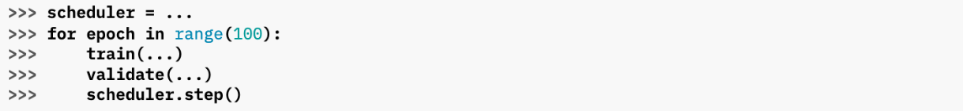

In [25]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                 mode      = 'min', 
                                                 factor    = 0.5,
                                                 patience  = 1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [26]:
def init_train_state(args):
    train_state_dict = {'stop_early'    : False,
                        'early_stopping_step'     : 0,
                        'early_stopping_best_val' : 1e8,
                        'learning_rate' : args.learning_rate,
                        'epoch_index'   : 0,
                        'train_loss'    : [],
                        'train_acc'     : [],
                        'val_loss'      : [],
                        'val_acc'       : [],
                        'test_loss'     : -1,
                        'test_acc'      : -1,
                        'model_filename': args.save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [27]:
train_state = init_train_state(args)
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 100000000.0,
 'learning_rate': 0.001,
 'epoch_index': 0,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [],
 'val_acc': [],
 'test_loss': -1,
 'test_acc': -1,
 'model_filename': 'ag_news_model.pth'}

## 3.2 - Helper function: compute accurary rate

In [28]:
def compute_accuracy(y_pred, y_target, device):
    y_target = y_target.to(device)

    ##### tensor.max(dim=1): the results include two output tensors (max, max_indices)
    _, y_pred_indices = y_pred.to(device).max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [29]:
##### An example - using classifier with initialized (random) parameters
one_batch = next(iter(dataloader))
classifier_temp(one_batch['x_data']).max(dim=1)

torch.return_types.max(
values=tensor([0.4159, 0.2389, 0.4885, 0.3660, 0.2290, 0.4163, 0.2018, 0.4285, 0.3909,
        0.2056], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1]))

In [30]:
outputs = classifier_temp(one_batch['x_data'])
_, pred = outputs.max(dim=1)  
targets = one_batch['y_target']
print('targets:', targets)
print('-'*80)
print('pred:',pred)
print('-'*80)
print('accurary rate:',compute_accuracy(outputs,targets,device='cpu'))

targets: tensor([3, 1, 0, 2, 2, 1, 2, 2, 2, 2])
--------------------------------------------------------------------------------
pred: tensor([2, 1, 1, 1, 1, 2, 2, 2, 2, 1])
--------------------------------------------------------------------------------
accurary rate: 40.0


## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [31]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [32]:
if args.get_model == 'TRAIN':
    ##### Get an initialized train_state
    train_state = init_train_state(args)
    
    for epoch_index in range(args.num_epochs):
        print('-'*60)
        print(f'Epoch {epoch_index}...')
        train_state['epoch_index'] = epoch_index

        ##################################################
        #####     Iterate over training dataset      #####
        ##################################################
        print('Training Iteration...')

        ##### Create a batch_generator using training data
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size = args.batch_size,
                                           device     = args.device)

        ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
        ##### when the loop ends, a moving average is just an average. 
        ##### In each epoch loop, they are reset to zero before the batch loop.
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “training mode” 
        # makes the model parameters mutable 
        # and enables regularization mechanisms like dropout
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            ##### STEP 1. zero the gradients
            # Inside each batch iteration, the optimizer’s gradients are first reset
            # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
            # is called earlier, the new gradient is accumulated on top of the one computed 
            # in previous iterations, which leads to an incorrect value for the gradient.
            # Therefore, use this zero_ method to reset the gradients.
            optimizer.zero_grad()

            ##### STEP 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            # update the moving average of loss, batch by batch
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
            # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
            # Note that the loss is the loss in train split. There is no valid_loss.backward()
            # because we don't want to train the model on the validation data. 
            loss.backward()

            ##### STEP 5. use optimizer to update parameters
            # the optimizer uses the propagated gradients to perform parameter updates
            # The value of classifier.parameters(), i.e., params is automatically updated in this step. 
            # In specific, the optimizer looks into params.grad and updates params, by substracting 
            # learning_rate * grad from it. 
            optimizer.step()

            ##### Tracking the accuracy
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            # update the moving average of acc, batch by batch
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (training) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        ##################################################
        #####     Iterate over validation dataset    #####
        ##################################################
        print('Validation Iteration...')

        ##### Create a batch_generator using validation data
        dataset.set_split('val')    
        batch_generator = generate_batches(dataset, 
                                           batch_size = args.batch_size, 
                                           device     = args.device)
        ##### Create new running loss, and running accuracy
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “evaluation mode”
        # makes the model parameters immutable 
        # disables dropout
        # disables computation of the loss and propagation of gradients back to the parameters
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            ##### compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (validation) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        ##### Update the status of Early Stopping and Model Checkpoint
        # Input: the current classifier and current train_state (end of the current epoch loop)
        # Update three items in train_state
        # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
        # 2."early_stopping_best_val" update to the current val_loss if it is the best model
        # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
        # Save a new model if the current model has early_stopping_best_val
        train_state = update_train_state(args = args, model = classifier,
                                         train_state = train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        print('Current lr:', optimizer.param_groups[0]['lr'])

        print_train_state(train_state)

        if train_state['stop_early']:
            break

elif args.get_model == 'LOAD':
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 0.7579
Train Accuracy: 69.91949
Valid Loss: 0.60087
Valid Accuracy: 78.00781
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 0.54488
Train Accuracy: 79.76491
Valid Loss: 0.55879
Valid Accuracy: 79.61496
early_stopping_best_val: 0.55879
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 0.50432
Train Accuracy: 81.03206
Valid Loss: 0.55962
Valid Accuracy: 79.51451
early_stopping_best_val: 0.55879
early_stopping_step: 1
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Val

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data

In [33]:
classifier = NewsClassifier(embedding_dim    = args.embedding_dim, 
                            num_embeddings   = len(vectorizer.title_vocab),
                            num_channels     = args.num_channels,
                            hidden_dim       = args.hidden_dim, 
                            num_classes      = len(vectorizer.category_vocab), 
                            dropout_p        = args.dropout_p,
                            pretrained_embeddings = embeddings,
                            padding_idx      = 0)
filename   = args.output_path+'ag_news_model.pth'
classifier.load_state_dict(torch.load(filename))
classifier = classifier.to(args.device)

In [34]:
loss_func  = nn.CrossEntropyLoss(dataset.class_weights)

In [35]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc = 0.0

##### Indicate that the model is in “evaluation mode”
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(batch_dict['x_data'])

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))

Test loss: 0.54427
Test Accuracy: 79.75446


## 4.2 Generation a prediction for a given surname

In [36]:
def get_random_sample(n_sample,category,split='test'):
    dataset.set_split(split)
    target_df = dataset._target_df
    if category not in target_df.category.unique():
        print("Invalid category")
        return
    target_df = target_df.loc[target_df['category']==category,:].sample(n_sample).reset_index()
    
    samples = {}
    samples[category] = target_df['title']
    
    return samples

In [37]:
def predict_category(title, classifier, vectorizer, max_length):
    
    def preprocess_text(text):
        text = ' '.join(word.lower() for word in text.split(" "))
        text = re.sub(r"([.,!?])", r" \1 ", text)
        text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
        return text
    
    classifier         = classifier.to(args.device)
    title            = preprocess_text(title)
    
    
    vectorized_title   = torch.tensor(vectorizer.vectorize(title,vector_length=max_length))

    output             = classifier(vectorized_title.unsqueeze(0), 
                                    apply_softmax=True)
    
    probability_value, index = output.max(dim=1)
    
    predicted_category = vectorizer.category_vocab.lookup_index(index.item())
    
    
    return {'category': predicted_category, 
            'probability': probability_value.item()}

In [38]:
samples = {}
n_sample = 10
for c in ['Business', 'Sci/Tech', 'Sports', 'World']:
    samples.update(get_random_sample(n_sample,c))

In [39]:
summary_table = pd.DataFrame(index  = ['Business', 'Sci/Tech', 'Sports', 'World'],
                             columns = ['Accurate Rate'])
for true_category, sample_group in samples.items():
    print(f"True Category: {true_category}")
    n_accurate = 0
    
    for sample in sample_group:
        print("-"*60)
        prediction = predict_category(sample, classifier, vectorizer, dataset._max_seq_length + 2)
        print("Sample:", sample)
        print("Prediction: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        if prediction['category'] == true_category:
            n_accurate+=1
    
    summary_table.loc[true_category,'Accurate Rate'] = n_accurate/len(sample_group)
    print("="*60)
    print()

True Category: Business
------------------------------------------------------------
Sample: 'Deal nearer' in BA strike talks
Prediction: Business (p=0.52)
------------------------------------------------------------
Sample: AirTran to acquire ATA #39;s Chicago gates
Prediction: Business (p=0.51)
------------------------------------------------------------
Sample: Yahoo sells \$191 millions in Google stock
Prediction: Business (p=0.97)
------------------------------------------------------------
Sample: Fed's McTeer: U.S. Economy Back on Track (Reuters)
Prediction: Business (p=0.95)
------------------------------------------------------------
Sample: Analyst: Outsourcing can save costs in health care
Prediction: Sci/Tech (p=0.94)
------------------------------------------------------------
Sample: Textile groups call for limits
Prediction: Business (p=0.32)
------------------------------------------------------------
Sample: USDA Tests Confirm Soy Rust in Florida
Prediction: Sci/Tech (

In [40]:
summary_table

,Accurate Rate
Business,0.8
Sci/Tech,0.4
Sports,1.0
World,0.5
